In [15]:
 !pip install opencv-python
 #==3.4.0.14
 !pip install opencv-contrib-pytho
 #==3.4.11.45

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-contrib-pytho (from versions: none)
ERROR: No matching distribution found for opencv-contrib-pytho


In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import random

In [4]:
def run_sift(img):
  im_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  sift = cv2.xfeatures2d.SIFT_create()
  kp , dest = sift.detectAndCompute(img,None)
  kp_img = cv2.drawKeypoints(im_gray,kp,None)
  return kp_img,kp,dest


In [5]:
def match(dest1,dest2):
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(dest1,dest2,k=2)
  matches = sorted(matches,key=lambda x:x[0].distance/x[1].distance)
  mymatch=[]
  for i,j in matches:
    if i.distance < 0.75 * j.distance:
      mymatch.append(i)
  return mymatch

In [6]:
def getPerspectiveTransformMatrix(p1, p2):
    matrixIndex = 0
    #A = np.zeros((8, 9))

    A=[]

    # print(p1)
    # print(p1[0][1])
    # print(p2)
    for i in range(0, len(p1)):
        # x = p1[i][0]
        # #print(i)
        # y = p1[i][1]

        # u = p2[i][0]
        # v = p2[i][1]

         # A[matrixIndex] = [-x, -y, -1, 0, 0, 0, u*x, u*y, u]
        # A[matrixIndex + 1] = [0, 0, 0, -x, -y, -1, v*x, v*y, v]

        # A[matrixIndex] = [0, 0, 0, -x, -y, -1, v*x, v*y, v]
        # A[matrixIndex + 1] = [x, y, 1, 0, 0, 0, -u*x, -u*y, -u]

        # matrixIndex = matrixIndex + 2

        x, y = p1[i][0], p1[i][1]
        u, v = p2[i][0], p2[i][1]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.asarray(A)
    U, s, V = np.linalg.svd(A)
    L = V[-1:]/V[-1,-1]
    matrix = L.reshape(3, 3)
    return matrix

In [7]:
def fitHomoMat(pointB,pointA):
  
        dstPoints = pointA
        srcPoints = pointB
        
        # RANSAC algorithm, selecting the best fit homography
        NumSample = len(pointA)
        threshold = 5.0  
        NumIter = 8000
        NumRamdomSubSample = 4
        MaxInlier = 0
        Best_H = None
        
        for run in range(NumIter):
            SubSampleIdx = random.sample(range(NumSample), NumRamdomSubSample) # get the Index of ramdom sampling
            H = getPerspectiveTransformMatrix(srcPoints[SubSampleIdx], dstPoints[SubSampleIdx])
            
            # find the best Homography have the the maximum number of inlier
            NumInlier = 0 
            for i in range(NumSample):
                if i not in SubSampleIdx:
                    concateCoor = np.hstack((srcPoints[i], [1]))
                    dstCoor = H @ concateCoor.T 
                    if dstCoor[2] <= 1e-8: 
                        continue
                    dstCoor = dstCoor / dstCoor[2]
                    if (np.linalg.norm(dstCoor[:2] - dstPoints[i]) < threshold):
                        NumInlier = NumInlier + 1
            if (MaxInlier < NumInlier):
                MaxInlier = NumInlier
                Best_H = H
                
        #print("The Number of Maximum Inlier:", MaxInlier)
        
        return Best_H

In [8]:
def alignimg(im1,im2,kp1,kp2,myMatch):
  pointA = np.float32([kp1[i.queryIdx].pt for i in myMatch]).reshape(-1,1,2)
  pointB = np.float32([kp2[i.trainIdx].pt for i in myMatch]).reshape(-1,1,2)

  #H,mask = cv2.findHomography(pointA,pointB,cv2.RANSAC)

  pointA = np.float32([kp1[i.queryIdx].pt for i in myMatch]).reshape(-1,2)
  pointB = np.float32([kp2[i.trainIdx].pt for i in myMatch]).reshape(-1,2)

  H,mask = cv2.findHomography(pointA,pointB,cv2.RANSAC)
  
  my1H = fitHomoMat(pointA,pointB)
  myH = getPerspectiveTransformMatrix(pointA,pointB)
  #M = cv2.getAffineTransform(pointA,pointB)
  print(H)
  print(myH)
  print(my1H)
  result = cv2.warpPerspective(im2,my1H,(im2.shape[1]+im1.shape[1],im2.shape[0]))
  #cv2_imshow(result)
  result[0:im1.shape[0],0:im1.shape[1]] = im1
  return result


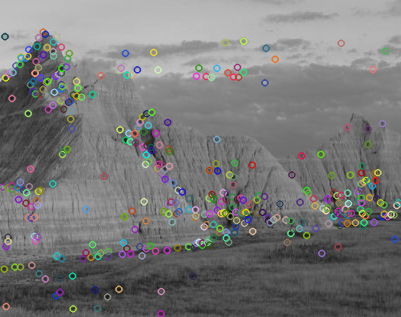

In [9]:
#right
im2 = cv2.imread('./c.jpg')
#left
im1 = cv2.imread('./b.jpg')

#im2 = cv2.resize(im2,None,fx=0.5,fy=0.5)

im2 = cv2.resize(im2,None,fx=1,fy=1)
im1 = cv2.resize(im1,(im2.shape[1],im2.shape[0]))

#right
kpimg1,kp1,dest1 = run_sift(im2)
#left
kpimg2,kp2,dest2 = run_sift(im1)

cv2_imshow(kpimg2)



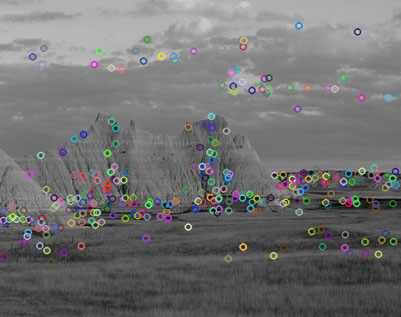

In [10]:
cv2_imshow(kpimg1)
#cv2_imshow(dest1)

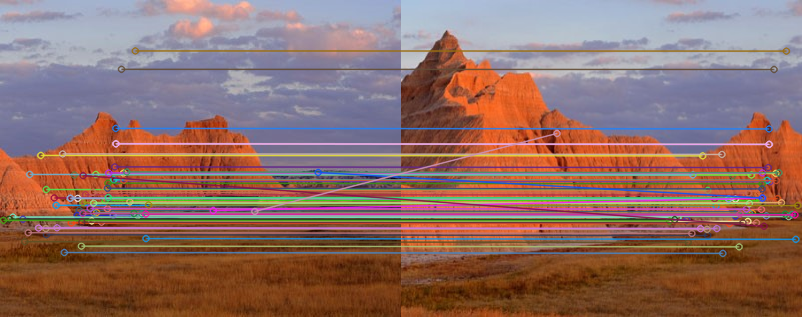

In [11]:
myMatch = match(dest1 , dest2)
selectMatchimg = cv2.drawMatches(im2,kp1,im1,kp2,myMatch,None,flags=2)
cv2_imshow(selectMatchimg)

[[ 8.95801783e-01  7.48865567e-04  2.65492615e+02]
 [ 5.70248894e-03  1.00695041e+00 -6.77279998e-01]
 [ 2.60743898e-05  3.31392640e-06  1.00000000e+00]]
[[-5.32167730e-01 -1.19247750e+00  3.57139051e+02]
 [-3.51033147e-01 -2.28848462e-01  1.17615593e+02]
 [-1.83642940e-03 -3.12363497e-03  1.00000000e+00]]
[[ 1.03153296e+00  9.91947334e-02  2.61809905e+02]
 [ 5.14715860e-02  1.12729739e+00 -1.22664304e+01]
 [ 2.49088172e-04  3.11090684e-04  1.00000000e+00]]


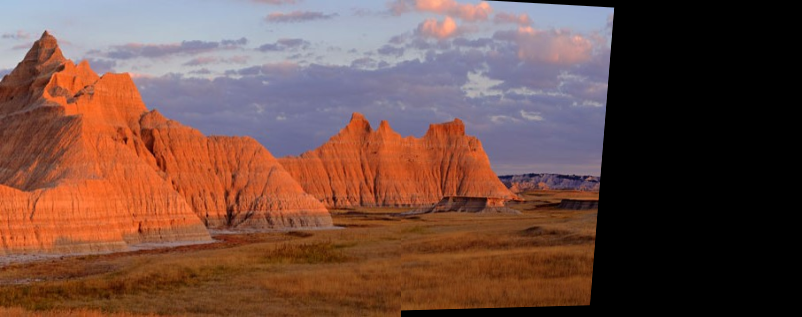

True

In [12]:
result = alignimg(im1,im2,kp1,kp2,myMatch)
cv2_imshow(result)
cv2.imwrite('middle.jpg', result)

[[ 2.02632837e+00 -5.97532157e-03  5.18043281e+02]
 [ 6.46259880e-03  9.94132985e-01 -4.57560861e-02]
 [ 3.42599083e-05 -1.33745120e-05  1.00000000e+00]]
[[-3.27093750e-01 -1.96714508e+00  6.02549153e+02]
 [-1.15667841e-01 -7.98612038e-02  6.66890537e+01]
 [-5.78468099e-04 -3.28603963e-03  1.00000000e+00]]
[[ 2.12667688e+00 -7.82486513e-02  5.19737277e+02]
 [ 2.22650993e-02  9.74315355e-01  4.18223446e-01]
 [ 2.39680939e-04 -1.30362476e-04  1.00000000e+00]]


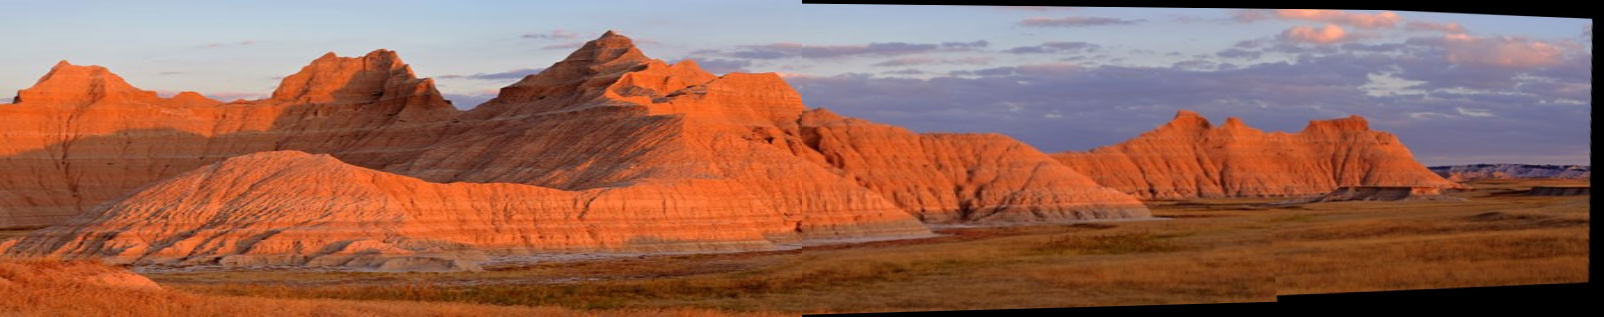

In [13]:
#right
im2 = cv2.imread('./middle.jpg')
#left
im1 = cv2.imread('./a.jpg')

im2 = cv2.resize(im2,None,fx=1,fy=1)
im1 = cv2.resize(im1,(im2.shape[1],im2.shape[0]))

#right
kpimg1,kp1,dest1 = run_sift(im2)
#left
kpimg2,kp2,dest2 = run_sift(im1)

myMatch = match(dest1 , dest2)
selectMatchimg = cv2.drawMatches(im2,kp1,im1,kp2,myMatch,None,flags=2)
#cv2_imshow(selectMatchimg)


result = alignimg(im1,im2,kp1,kp2,myMatch)
cv2_imshow(result)